# Head direction analysis demo

This notebook demonstrates how to use the `head_direction` package to analyze neural data. 

We will:
1. **Generate synthetic data**: Simulate a rat running in a circle and a neuron that fires when the rat faces "North" ($90^\circ$).
2. **Calculate head direction**: Compute the head angle from two tracked LEDs.
3. **Compute tuning curves**: Calculate the firing rate as a function of head angle.
4. **Score the cell**: Calculate the Mean Vector Length to quantify how directional the cell is.
5. **Visualize**: Plot the trajectory and the polar tuning curve.
6. **Auto-calibrating unknown LED placements**: Demonstrate how to auto-calibrate data when the LED orientation is unknown (e.g., side-mounted LEDs).

In [1]:
import matplotlib.pyplot as plt
import neo
import numpy as np
import quantities as pq

from head_direction import (
    head_direction,
    head_direction_rate,
    head_direction_score,
)

## 1. Generate synthetic data

We simulate 60 seconds of data where an animal runs in continuous circles. We also simulate two LEDs (front and back) on the animal's head.

In [2]:
# Simulation parameters
duration = 60.0  # seconds
dt = 0.01  # 10ms time steps (100 Hz tracking)
n_samples = int(duration / dt)
t = np.linspace(0, duration, n_samples)

# Initialize random number generator
rng = np.random.default_rng(seed=42)

# Simulate head angle
# The animal runs counter-clockwise and completes one full rotation every 10s.
# Note: If position is at angle theta, movement direction (tangent) is theta + pi/2
theta = (2 * np.pi * t / 10.0) % (2 * np.pi)
true_head_angle = (theta + np.pi / 2) % (2 * np.pi)

# Simulate position (running in a circle of radius 50cm)
radius = 50.0
pos_x = radius * np.cos(theta)
pos_y = radius * np.sin(theta)

# Simulate LEDs
# LED1 (Front/Nose) is at the animal's position
led1_x = pos_x.copy()
led1_y = pos_y.copy()

# LED2 (Back/Neck) is behind the animal, opposite to the movement vector
led_dist = 5.0
led2_x = led1_x - led_dist * np.cos(true_head_angle)
led2_y = led1_y - led_dist * np.sin(true_head_angle)

# Add noise to tracking data
noise_level = 0.2
led1_x += rng.normal(0, noise_level, n_samples)
led1_y += rng.normal(0, noise_level, n_samples)
led2_x += rng.normal(0, noise_level, n_samples)
led2_y += rng.normal(0, noise_level, n_samples)

### Simulate a head direction cell

We simulate a neuron that prefers to fire when the animal is facing **North ($90^\circ$ or $\pi/2$ radians)**.

In [3]:
# Preferred direction: pi/2 (90 degrees)
preferred_angle = np.pi / 2
baseline_rate = 2.0  # Hz
max_rate = 50.0  # Hz
kappa = 5.0  # Sharpness of tuning (Von Mises concentration)

# Calculate instantaneous firing rate based on current head angle
# Von Mises tuning function (circular Gaussian)
inst_rate = max_rate * np.exp(kappa * np.cos(true_head_angle - preferred_angle)) / np.exp(kappa)
inst_rate += baseline_rate

# Generate spikes using a Poisson process
spike_probability = inst_rate * dt
is_spike = rng.random(n_samples) < spike_probability
spike_times_array = t[is_spike]

# Wrap in Neo SpikeTrain to demonstrate duck typing support
spike_train = neo.SpikeTrain(spike_times_array * pq.s, t_stop=duration * pq.s)

print(f"Generated {len(spike_train)} spikes.")

Generated 654 spikes.


## 2. Calculate head direction

We use the tracked LED positions to reconstruct the head angle.

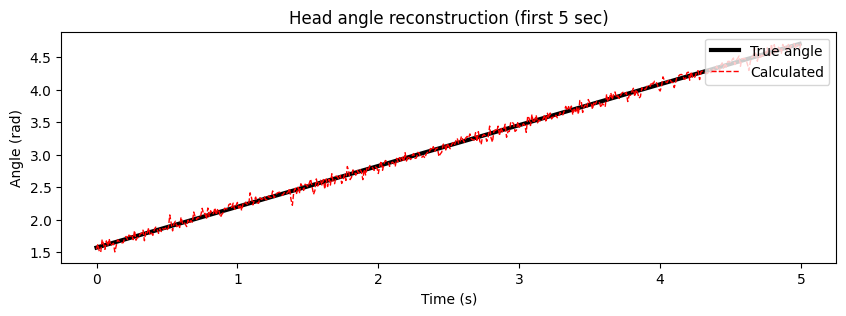

In [4]:
# Calculate head direction (default Front/Back LEDs assumption)
calc_angles, calc_times = head_direction(led1_x, led1_y, led2_x, led2_y, t, std_filter_threshold=3.0)

# Visualization: compare true vs calculated
plt.figure(figsize=(10, 3))
plt.plot(t[:500], true_head_angle[:500], "k-", lw=3, label="True angle")
plt.plot(calc_times[:500], calc_angles[:500], "r--", lw=1, label="Calculated")

plt.ylabel("Angle (rad)")
plt.xlabel("Time (s)")
plt.legend(loc="upper right")
plt.title("Head angle reconstruction (first 5 sec)")
plt.show()

## 3. Compute tuning curve

Now we calculate the firing rate as a function of the calculated head angle.

In [5]:
angle_bins, tuning_curve = head_direction_rate(
    spike_train,
    calc_angles,
    calc_times,
    num_bins=36,
    smoothing_window=3,
)

## 4. Score the cell

We calculate the Mean Vector Length (Rayleigh vector) to see how strongly directional this cell is. A value close to 1.0 means perfect directionality; close to 0.0 means uniform firing.

In [6]:
mean_angle, vector_length = head_direction_score(angle_bins, tuning_curve)

print(f"Mean Angle: {np.degrees(mean_angle):.1f} degrees")
print(f"Vector Length: {vector_length:.4f}")

# Note: Since our synthetic cell prefers 90 degrees, Mean Angle should be close to 90.

Mean Angle: 90.6 degrees
Vector Length: 0.7042


## 5. Visualization

We create a standard polar plot to visualize the tuning curve.

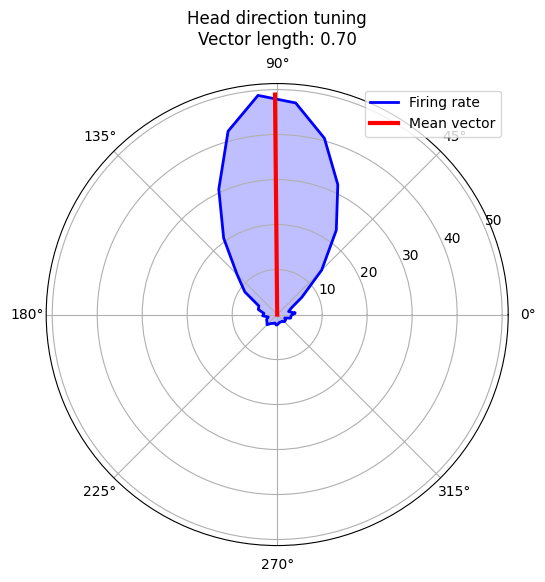

In [7]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="polar")

# Plot the tuning curve
# We append the first point to the end to close the circle line
theta = np.concatenate((angle_bins, [angle_bins[0]]))
r = np.concatenate((tuning_curve, [tuning_curve[0]]))

ax.plot(theta, r, linewidth=2, color="b", label="Firing rate")
ax.fill(theta, r, alpha=0.25, color="b")

# Plot the mean vector direction
ax.plot([0, mean_angle], [0, np.max(tuning_curve)], "r-", lw=3, label="Mean vector")

ax.set_title(f"Head direction tuning\nVector length: {vector_length:.2f}", va="bottom")
ax.legend()
plt.show()

## 6. Auto-calibrating unknown LED placements

In real-world experiments, LEDs are not always mounted Front/Back. They might be mounted on the ears (side-by-side) or inverted. This introduces a systematic angular error.

The `head_direction` package includes a utility `get_alignment_offset` that compares the calculated head angle with the animal's movement vector to automatically detect and correct this offset.

True System Offset: -90.0 deg
Detected Offset:    -90.0 deg


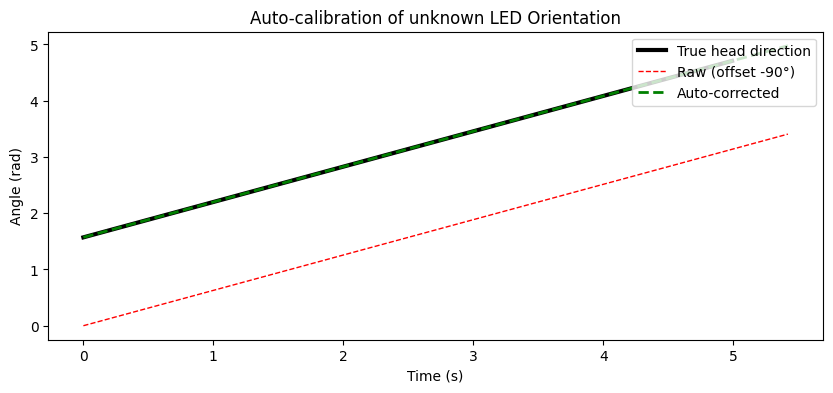

In [8]:
from head_direction import get_alignment_offset

# 1. Simulate "unknown" LED placement (e.g., Side-by-Side / Ears)
# This corresponds to a -90 degree (-pi/2) offset relative to the nose.
true_offset_rad = -np.pi / 2

# Rotate the LED positions around the center of the animal
# (We reuse pos_x, pos_y, true_head_angle from the main demo)
rotated_led1_x = pos_x + led_dist * np.cos(true_head_angle + true_offset_rad)
rotated_led1_y = pos_y + led_dist * np.sin(true_head_angle + true_offset_rad)
rotated_led2_x = pos_x - led_dist * np.cos(true_head_angle + true_offset_rad)
rotated_led2_y = pos_y - led_dist * np.sin(true_head_angle + true_offset_rad)

# 2. Calculate raw head direction
# Without knowing the offset, we assume 0.0. The result will be rotated by -90 deg.
raw_angles, raw_times = head_direction(rotated_led1_x, rotated_led1_y, rotated_led2_x, rotated_led2_y, t)

# 3. Auto-detect the system offset
# We need to pass the centroid of the animal for the movement vector calculation.
# IMPORTANT: We must filter the centroid to match the timestamps returned by head_direction!
valid_mask = np.isin(t, raw_times)
centroid_x = ((rotated_led1_x + rotated_led2_x) / 2)[valid_mask]
centroid_y = ((rotated_led1_y + rotated_led2_y) / 2)[valid_mask]

detected_offset = get_alignment_offset(raw_angles, centroid_x, centroid_y, raw_times)

print(f"True System Offset: {np.degrees(true_offset_rad):.1f} deg")
print(f"Detected Offset:    {np.degrees(detected_offset):.1f} deg")

# 4. Recalculate with correction
corrected_angles, _ = head_direction(
    rotated_led1_x, rotated_led1_y, rotated_led2_x, rotated_led2_y, t, offset=detected_offset
)

# 5. Visualization
plt.figure(figsize=(10, 4))
plt.plot(t[:500], true_head_angle[:500], "k-", lw=3, label="True head direction")
plt.plot(raw_times[:500], raw_angles[:500], "r--", lw=1, label=f"Raw (offset {np.degrees(true_offset_rad):.0f}°)")
plt.plot(raw_times[:500], corrected_angles[:500], "g--", lw=2, label="Auto-corrected")

plt.legend(loc="upper right")
plt.title("Auto-calibration of unknown LED Orientation")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.show()